# Compare Diligence Estimates

Simulate multiple models of students with varying noise and compare diligence estimates with each

## Setup

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
from datetime import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [6]:
from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.binary_skill_cog import BinarySkillCognition
from learner.decider import *

from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import SimulationBatch

from analytics.batch import *
from analytics.student_stats import StudentStatCalc
from analytics.featurization import *
from analytics.cae import *

from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper


In [7]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [13]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.cae:Base directory for the project:
/rdata/Sandbox/MotivSim


In [9]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.cae:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-dbe9c7fc-3df7-48b3-8df1-39ec82148452
INFO:analytics.cae:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [10]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 67 documents
INFO:log_db.mongo:collection name, caa_batches, has 8 documents
INFO:log_db.mongo:collection name, simbatches, has 3 documents
INFO:log_db.mongo:collection name, caa_models, has 800 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 600 documents
INFO:log_db.mongo:collection name, units, has 2 documents
INFO:log_db.mongo:collection name, decisions, has 1589503 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 7577 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 600 documents
INFO:log_db.mongo:collection name, problems, has 1904 documents
INFO:log_db.mongo:collection name, actions, has 1589503 documents
INFO:log_db.mongo:collection name, sections, has 14 documents
INFO:log_db.mongo:collection name, tutor_events, has 1433293 documents


In [10]:
clear_db = False
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.cae:Skipping Clearing database


## 1. Simulating learners

In [11]:
num_students = 200

In [12]:
def gen_students(num_students, domain, curric, 
                 cog_mod, dec_mod):
    stus = []
    for i in range(num_students):
        cog = cog_mod(domain)
        dec = dec_mod()
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(domain, curric, students, batch):    
    for i, stu in enumerate(students):
        logger.info("Simulating student #%i" % i)
        sim = ModLearnerSimulation(domain, curric, stu)
        batch.add_sim(sim)
        sim.run()
        
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


### Generate Curriculum

In [13]:
new_curric = None
new_domain = None

In [14]:
def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        domain_params = {'m_l0': 0.45,
                         'sd_l0': 0.155,
                         'm_t': 0.25,
                         'sd_t': 0.13,#0.03,
                         'm_s': 0.155,
                         'sd_s': 0.055,
                         'm_g': 0.15,#0.6,
                         'sd_g': 0.105
                        }
        curric_params = {'num_units': 2,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

### Simple Diligent students

In [15]:
sim_batch_desc = "Simple diligent students"
cog_mod = BinarySkillCognition
dec_mod = EVDecider

In [16]:
simbatch = db.simbatches.find_one({"desc": sim_batch_desc})
if simbatch is None:
    logger.info("Generating new simulation. None found in db")

    # generate simualted data for test
    domain, curric = gen_test_curric(db, db_params)
    students = gen_students(num_students, 
                            domain, curric,
                            cog_mod, dec_mod)    
    logger.info(f"Persisting {len(students)} initialized students to db")
    db.students.insert_many([stu.to_dict() for stu in students])
    batch = SimulationBatch(sim_batch_desc)
    simulate_students(domain, curric, students, batch)    
    logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
else:
    logger.info(f"Found simulation batch: {str(simbatch)}")
    lmapper = DBLearnerMapper(db)
    students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
    batch = SimulationBatch.from_dict(simbatch)
    logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")


INFO:analytics.cae:Found simulation batch: {'_id': '54935595-da2e-4e72-a71d-e1497f4c0bb3', 'run_time': datetime.datetime(2021, 1, 8, 5, 32, 45, 859000), 'desc': 'Simple diligent students', 'student_ids': ['3d74792e-e397-49d8-822f-c5ab8b01e1f0', 'd319c5a9-dee5-48be-8dcb-22dd6c1fdb6f', 'a3c1a477-36a9-421d-b022-59de0e383642', 'b8e2b263-4e5a-421a-aabe-8551624b79d4', '99aa2c7a-7808-4e31-bda4-590e9ccb41da', '008ad67c-1766-4921-8f5c-f82090b7faf7', '74b7f8b0-c7ad-47b3-9806-e8ed1795cd5c', '1d035537-71a8-4343-bdeb-f8d77fcb9c89', '1fa35783-062f-4189-b985-ec4e4bada1e9', 'aefd3f3a-255f-4540-9a66-3fadf798bc01', 'ae730e6f-6cb0-4d12-8711-2e7225eaba14', '4fef3a78-fcf3-4c9e-9c0a-7b793574dc0f', '35643369-d216-44bf-b47a-e873495adc4d', 'e37f9f87-22aa-4329-ab20-0c8d1b233fdc', 'd2657734-68c9-4f74-9f49-ca3eeed2ce85', '5f8308ea-bfc5-49b7-8d35-ced038735dc6', '9b97b7a5-1407-496a-ad67-6c115f5093ca', 'b456057f-02ec-4926-b4fb-bb3b9a1a1cb5', '9654063f-8344-4d69-953f-4613e2c8e487', 'c425b472-66ae-4d37-868c-5bfcab33f1

### Diligent Students with variable values

In [17]:
sim_batch_desc = "Diligent Students with variable values"
cog_mod = BinarySkillCognition
dec_mod = RandValDecider

In [18]:
simbatch = db.simbatches.find_one({"desc": sim_batch_desc})
if simbatch is None:
    logger.info("Generating new simulation. None found in db")

    # generate simualted data for test
    domain, curric = gen_test_curric(db, db_params)
    students = gen_students(num_students, 
                            domain, curric,
                            cog_mod, dec_mod)    
    logger.info(f"Persisting {len(students)} initialized students to db")
    db.students.insert_many([stu.to_dict() for stu in students])
    batch = SimulationBatch(sim_batch_desc)
    simulate_students(domain, curric, students, batch)    
    logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
else:
    logger.info(f"Found simulation batch: {str(simbatch)}")
    lmapper = DBLearnerMapper(db)
    students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
    batch = SimulationBatch.from_dict(simbatch)
    logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")


INFO:analytics.cae:Found simulation batch: {'_id': '78ea7cc5-d11b-46c8-b705-d6aebb5a1123', 'run_time': datetime.datetime(2021, 1, 8, 5, 55, 18, 580000), 'desc': 'Diligent Students with variable values', 'student_ids': ['bbee4d23-9cbd-4375-a9cd-ca942cc57f03', '57f87f30-afe3-49c1-ac27-dd05f66be88b', '11ccf625-bfa9-40a5-8d27-f8576da8c7d0', 'c6698a16-1577-47ae-8619-1d63f7de4f31', '7f642220-464f-4594-8702-a2a65310eaba', '4912a065-91fc-4590-81b0-80fbf257ff54', '14b0b0b6-7c54-4f8a-af93-bd3958223015', '5602c672-e856-4652-9608-23656a939403', '908f6423-cf31-4c77-9764-fb42eab68d96', '0b2c8645-adea-4acf-8310-2a12266edb7d', 'e08c6269-9df2-4d23-98d3-27f3a1ef1486', '99419972-27ed-402f-be2a-488a2652b078', '7de4997b-a89e-4a1e-a415-d96f688a56d7', 'd5e3fcc9-359a-40a8-add8-aec66abd2451', 'a6f7b9b6-e916-4869-ae48-ae55af37e0fc', '0112b916-c447-43e2-8b56-9e94b34d1fed', '7b6ab041-7fbd-4446-8b94-41a3cb4fbb73', '5b87770d-e04d-4ace-b7d7-3200779a13e2', '8bd15e58-b8dc-4a1f-9dce-eaa4575bcaf3', '2b7010fe-975d-480f-a

### Diligent Students with domain-level self-efficacy

In [19]:
sim_batch_desc = "Diligent Students with domain-level self-efficacy"
cog_mod = BinarySkillCognition
dec_mod = DomainSelfEffDecider

In [20]:
simbatch = db.simbatches.find_one({"desc": sim_batch_desc})
if simbatch is None:
    logger.info("Generating new simulation. None found in db")

    # generate simualted data for test
    domain, curric = gen_test_curric(db, db_params)
    students = gen_students(num_students, 
                            domain, curric,
                            cog_mod, dec_mod)    
    logger.info(f"Persisting {len(students)} initialized students to db")
    db.students.insert_many([stu.to_dict() for stu in students])
    batch = SimulationBatch(sim_batch_desc)
    simulate_students(domain, curric, students, batch)    
    logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
else:
    logger.info(f"Found simulation batch: {str(simbatch)}")
    lmapper = DBLearnerMapper(db)
    students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
    batch = SimulationBatch.from_dict(simbatch)
    logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")


INFO:analytics.cae:Found simulation batch: {'_id': '78f11a8c-24d4-43bf-aaf8-5855d5bf2908', 'run_time': datetime.datetime(2021, 1, 8, 6, 23, 14, 365000), 'desc': 'Diligent Students with domain-level self-efficacy', 'student_ids': ['94e09bca-7dd3-4a07-9fa8-0fbaaec4743b', '28bc4471-cbe9-4f14-8d13-34c79f4b2359', 'cdfe5967-5c9d-4459-bb93-c64ed8530516', 'd956a72e-f4a7-4a31-803c-ef917d976ac5', 'da400001-e2da-4c73-b7c0-5cf0e37704dd', '1311cc72-a12b-4093-8b71-a390484d658d', 'f2a0f3ea-ff9b-41a4-9d49-a338ae23078a', '14e090a5-1988-476c-b48b-f83b975636f8', 'f0141baf-2e94-4951-b17a-ecf0c3e45f9a', 'e8bf5821-3cba-4916-beee-bb2c6177aea6', '65939fc6-44f3-4282-94d6-fbb26c49fa49', '41a3a415-e3af-47f1-adfb-a4ffe4dfd3f9', 'c8ba9276-c258-4b71-a260-b4fb63f31489', '2cd16efd-4d2b-4920-a780-f88bc4927d57', '0cc59748-6184-485a-8f57-efa8c65d31c2', '19165a5f-fa3b-42a7-a377-b07d8541340e', 'fe07b70a-d87c-4963-a040-85e868065bc4', 'b3eacd7d-e86d-4a86-8c4b-bd9303eb07b0', '0ea33c28-df1d-4570-b1c0-ac03f49ac054', '6318da57-

## 2. EDA of simulated Data

In [114]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 67 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 3 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 600 documents
INFO:log_db.mongo:collection name, units, has 2 documents
INFO:log_db.mongo:collection name, decisions, has 1589503 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 7577 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 600 documents
INFO:log_db.mongo:collection name, problems, has 1904 documents
INFO:log_db.mongo:collection name, actions, has 1589503 documents
INFO:log_db.mongo:collection name, sections, has 14 documents
INFO:log_db.mongo:collection name, tutor_events, has 1433293 documents


In [115]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_desc = ["Simple diligent students",
              "Diligent Students with variable values",
              "Diligent Students with domain-level self-efficacy"]
sids = {desc: [] for desc in batch_desc}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_desc:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.cae:batch #0: 
ID: 54935595-da2e-4e72-a71d-e1497f4c0bb3
desc: Simple diligent students
INFO:analytics.cae:recovered 200 student ids for batch Simple diligent students
INFO:analytics.cae:batch #1: 
ID: 78ea7cc5-d11b-46c8-b705-d6aebb5a1123
desc: Diligent Students with variable values
INFO:analytics.cae:recovered 200 student ids for batch Diligent Students with variable values
INFO:analytics.cae:batch #2: 
ID: 78f11a8c-24d4-43bf-aaf8-5855d5bf2908
desc: Diligent Students with domain-level self-efficacy
INFO:analytics.cae:recovered 200 student ids for batch Diligent Students with domain-level self-efficacy


In [139]:
# Batch analytic calculation
def batch_calc(db, calc, filt, batch_size, ):
    #filt is a list of ids
    batches = (filt[i:i+batch_size] for i in range(0, len(filt), batch_size))
    results = []
    for batch in batches:
        results.append(calc(batch))
    return pd.concat(results, axis=0)

In [140]:
def time_calc(calc, args):
    start = dt.now()
    result = calc(*args)
    end = dt.now()
    runtime = (end - start).total_seconds()
    return result, runtime

In [141]:
def get_tx_fields(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    return tx.loc[:, ["_id", 'stu_id', 'kc', 'unit_id', 'section_id', 'prob_id', 'step_id', "duration"]]

In [142]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)

### Simple Diligent Students

#### Student Parameters

In [ ]:
sid = sids[batch_desc[0]][0]

In [ ]:
args = [db, calc.get_stu_parameters, sid, 10]
sim_students, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student params: (200, 23)	Runtime: 0.46909 seconds


In [ ]:
args = [db, calc.action_stats, sid, 10]
action_dist, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student action stats: (200, 9)	Runtime: 37.022773 seconds


In [ ]:
args = [db, calc.total_tx_stats, sid, 10]
tx_stats, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student activity stats: (200, 9)	Runtime: 39.443621 seconds


In [ ]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

INFO:analytics.cae:Merged new stats together: (200, 41)


In [ ]:

sim_students.head()

,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,cog,decider,total_attempts,...,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,pct success,values,diligence
_id,,,,,,,,,,,,,,,,,,,,,
008ad67c-1766-4921-8f5c-f82090b7faf7,2116d859-d39d-4b11-8da8-28b22b15ff33,Modular Learner,{'903f30ec-c530-494b-bccb-540fb4146c46': False...,30,1800,3,1,{'domain_id': '2116d859-d39d-4b11-8da8-28b22b1...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,602,34,67,67,0.507463,1.000000,0,0.571700,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.978019
1d035537-71a8-4343-bdeb-f8d77fcb9c89,2116d859-d39d-4b11-8da8-28b22b15ff33,Modular Learner,"{'903f30ec-c530-494b-bccb-540fb4146c46': True,...",30,1800,3,1,{'domain_id': '2116d859-d39d-4b11-8da8-28b22b1...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,730,29,66,67,0.432836,0.985075,1,0.574351,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.272757
1fa35783-062f-4189-b985-ec4e4bada1e9,2116d859-d39d-4b11-8da8-28b22b15ff33,Modular Learner,{'903f30ec-c530-494b-bccb-540fb4146c46': False...,30,1800,3,1,{'domain_id': '2116d859-d39d-4b11-8da8-28b22b1...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,1351,26,67,67,0.388060,1.000000,0,0.619441,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.884053
3d74792e-e397-49d8-822f-c5ab8b01e1f0,2116d859-d39d-4b11-8da8-28b22b15ff33,Modular Learner,{'903f30ec-c530-494b-bccb-540fb4146c46': False...,30,1800,3,1,{'domain_id': '2116d859-d39d-4b11-8da8-28b22b1...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,776,33,65,67,0.492537,0.970149,2,0.627324,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",1.831674
74b7f8b0-c7ad-47b3-9806-e8ed1795cd5c,2116d859-d39d-4b11-8da8-28b22b15ff33,Modular Learner,{'903f30ec-c530-494b-bccb-540fb4146c46': False...,30,1800,3,1,{'domain_id': '2116d859-d39d-4b11-8da8-28b22b1...,"{'type': 'EVDecider', 'values': {'attempt': 10...",0,...,1157,35,67,67,0.522388,1.000000,0,0.497849,"{'attempt': 10, 'guess': 2.5, 'hint request': ...",2.109031


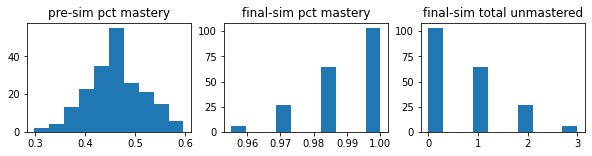

INFO:analytics.cae:Total skills: 67


In [ ]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


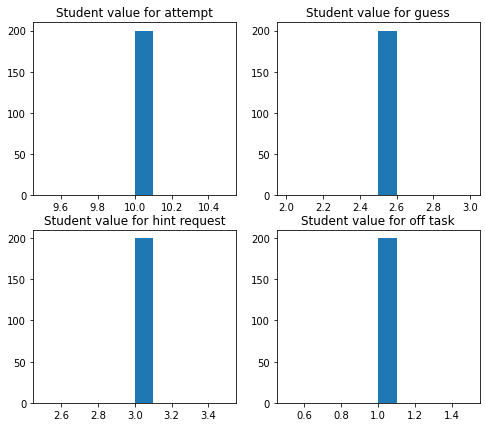

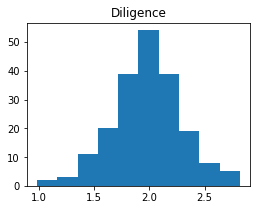

In [ ]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Decisions EDA

In [ ]:
# Get Learner decisions
if "stus_1" in globals():
    decisions = pd.DataFrame(db.decisions.find({"student_id": {'$in': [stu._id for stu in stus_1]}}))
else:
    decisions = pd.DataFrame(db.decisions.find({"student_id": {'$in': sid}}))
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

,_id,student_id,choice,time,action_evs,pev,problem,step,kc,learner_knowledge,attempt,hints_avail,hints_used,learner_off_task,self_eff,kcid
0,3a5c9aaa-f5c1-4b87-ab63-2832241ea5dc,f6098683-575a-48fa-8a73-a700c147de0f,Attempt,2021-01-08 05:32:45.863,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.5712467813888631, 0.028668383259273005, 0.3...",5f8cc19c-0d51-46c5-97f7-27f13a6a157d,2718ab37-51d1-4fde-9ff1-d5b6d2e04461,{'_id': '903f30ec-c530-494b-bccb-540fb4146c46'...,False,0,3,0,False,,903f30ec-c530-494b-bccb-540fb4146c46
1,1391023a-b1ce-45b8-9ca5-ba79def86b2a,f6098683-575a-48fa-8a73-a700c147de0f,Attempt,2021-01-08 05:32:49.735,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.5712467813888631, 0.028668383259273005, 0.3...",5f8cc19c-0d51-46c5-97f7-27f13a6a157d,34845c1a-bf7b-4bde-8551-086476aa56f9,{'_id': 'da3d056a-6a7c-4ca0-9b00-6b50d5466d0a'...,False,0,3,0,False,,da3d056a-6a7c-4ca0-9b00-6b50d5466d0a
2,3738999f-04ee-4509-8894-cfbc5c1f2d6d,f6098683-575a-48fa-8a73-a700c147de0f,Attempt,2021-01-08 05:32:53.446,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.5712467813888631, 0.028668383259273005, 0.3...",5f8cc19c-0d51-46c5-97f7-27f13a6a157d,34845c1a-bf7b-4bde-8551-086476aa56f9,{'_id': 'da3d056a-6a7c-4ca0-9b00-6b50d5466d0a'...,False,1,3,0,False,,da3d056a-6a7c-4ca0-9b00-6b50d5466d0a
3,f26076f6-19ba-4d66-ab0f-8c124413b409,f6098683-575a-48fa-8a73-a700c147de0f,Attempt,2021-01-08 05:32:55.182,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.5712467813888631, 0.028668383259273005, 0.3...",5f8cc19c-0d51-46c5-97f7-27f13a6a157d,ae1c3486-0fdf-48e9-bb4b-a2c463678419,{'_id': '8df4441b-e702-450a-a20b-5d712b9fafb8'...,False,0,3,0,False,,8df4441b-e702-450a-a20b-5d712b9fafb8
4,032a0c8b-90d7-4f31-b5c3-0f9f91ebe5bd,f6098683-575a-48fa-8a73-a700c147de0f,Attempt,2021-01-08 05:33:07.882,"{'Attempt': {'expectancy': 0.5, 'value': 10, '...","[0.5712467813888631, 0.028668383259273005, 0.3...",5f8cc19c-0d51-46c5-97f7-27f13a6a157d,ae1c3486-0fdf-48e9-bb4b-a2c463678419,{'_id': '8df4441b-e702-450a-a20b-5d712b9fafb8'...,False,1,3,0,False,,8df4441b-e702-450a-a20b-5d712b9fafb8


#### Learner Actions EDA

In [ ]:
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total actions,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
008ad67c-1766-4921-8f5c-f82090b7faf7,1024,29,224,86,1363,0.751284,0.021277,0.164343,0.063096
1d035537-71a8-4343-bdeb-f8d77fcb9c89,1238,33,391,104,1766,0.701019,0.018686,0.221404,0.058890
1fa35783-062f-4189-b985-ec4e4bada1e9,2109,72,724,184,3089,0.682745,0.023309,0.234380,0.059566
3d74792e-e397-49d8-822f-c5ab8b01e1f0,1198,39,367,124,1728,0.693287,0.022569,0.212384,0.071759
74b7f8b0-c7ad-47b3-9806-e8ed1795cd5c,2262,62,549,227,3100,0.729677,0.020000,0.177097,0.073226


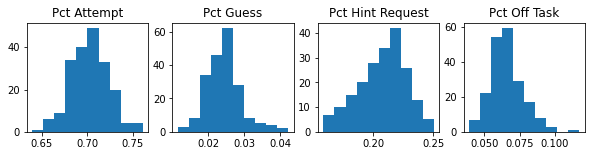

In [ ]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [ ]:
args = [db, get_tx_fields, sid, 10]
tx, runtime = time_calc(batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

INFO:analytics.cae:Extracted tx for set of students in 36.315992 seconds: (442114, 8)


In [ ]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

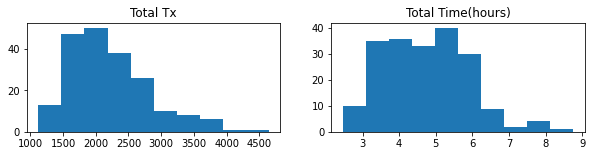

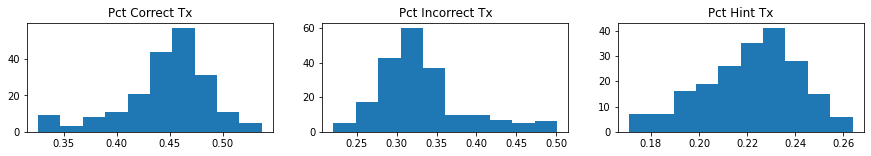

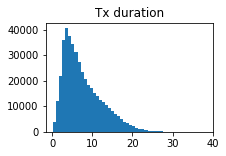

In [ ]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(tx_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(tx_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(tx_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(tx_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(tx_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

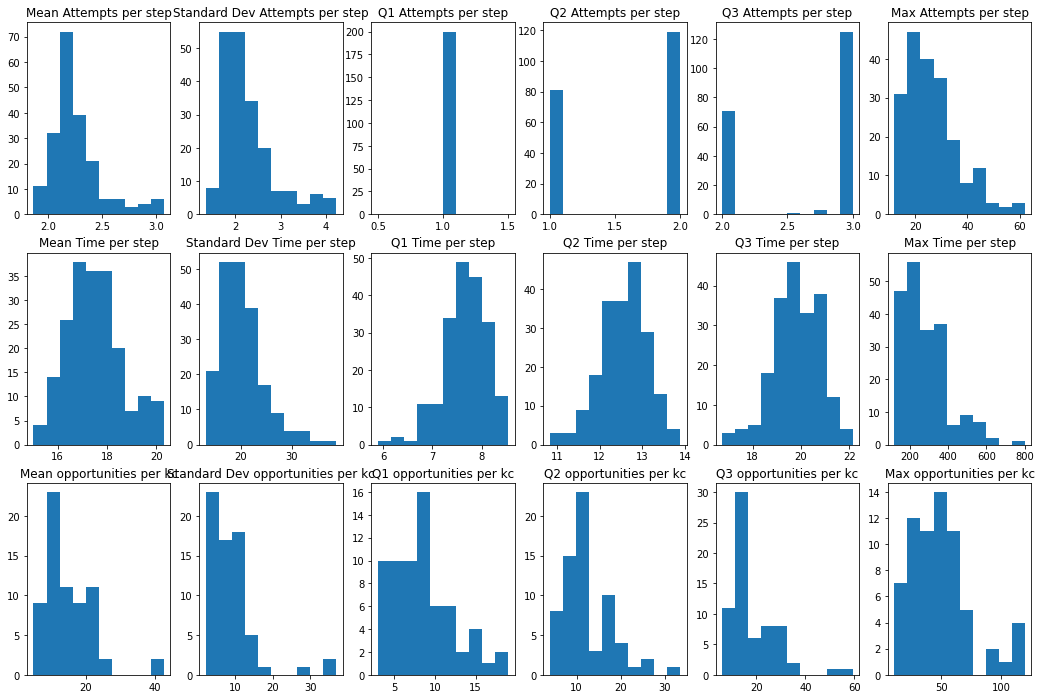

In [ ]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Diligent with variable values

In [ ]:
sid = sids[batch_desc[1]][0]

In [ ]:
args = [db, calc.get_stu_parameters, sid, 10]
sim_students, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student params: (200, 23)	Runtime: 0.453909 seconds


In [ ]:
args = [db, calc.action_stats, sid, 10]
action_dist, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

INFO:analytics.cae:Calculated student action stats: (200, 9)	Runtime: 44.205446 seconds


In [ ]:
args = [db, calc.total_tx_stats, sid, 10]
tx_stats, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

KeyboardInterrupt: 

In [ ]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

#### Student Parameters

In [ ]:
sim_students.head()

In [ ]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

In [ ]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Actions EDA

In [ ]:
action_dist.head()

In [ ]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [ ]:
args = [db, get_tx_fields, sid, 10]
tx, runtime = time_calc(batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

In [ ]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

In [ ]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

In [ ]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Diligent with domain-level self-eff

In [ ]:
sid = sids[batch_desc[2]][0]

In [ ]:
args = [db, calc.get_stu_parameters, sid, 10]
sim_students, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

In [ ]:
args = [db, calc.action_stats, sid, 10]
action_dist, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

In [ ]:
args = [db, calc.total_tx_stats, sid, 10]
tx_stats, runtime = time_calc(batch_calc, args)
logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

In [ ]:
    
stu_stats = pd.concat([sim_students, action_dist, tx_stats], axis=1)
logger.info(f"Merged new stats together: {stu_stats.shape}")

#### Student Parameters

In [ ]:
sim_students.head()

In [ ]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

In [ ]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()



#### Learner Actions EDA

In [ ]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [ ]:
args = [db, get_tx_fields, sid, 10]
tx, runtime = time_calc(batch_calc, args)
logger.info(f"Extracted tx for set of students in {runtime} seconds: {tx.shape}")

In [ ]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

In [ ]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

In [ ]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


## 3. Estimating Diligence

#### Train-test split

In [21]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_desc = ["Simple diligent students",
              "Diligent Students with variable values",
              "Diligent Students with domain-level self-efficacy"]
sids = {desc: [] for desc in batch_desc}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_desc:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.cae:batch #0: 
ID: 54935595-da2e-4e72-a71d-e1497f4c0bb3
desc: Simple diligent students
INFO:analytics.cae:recovered 200 student ids for batch Simple diligent students
INFO:analytics.cae:batch #1: 
ID: 78ea7cc5-d11b-46c8-b705-d6aebb5a1123
desc: Diligent Students with variable values
INFO:analytics.cae:recovered 200 student ids for batch Diligent Students with variable values
INFO:analytics.cae:batch #2: 
ID: 78f11a8c-24d4-43bf-aaf8-5855d5bf2908
desc: Diligent Students with domain-level self-efficacy
INFO:analytics.cae:recovered 200 student ids for batch Diligent Students with domain-level self-efficacy


In [22]:
# Random train-test split
test_ratio = 0.2
tt_split_sids = {}
for desc, sid in sids.items():
    n = len(sid[0])
    ntest = round(test_ratio*n)
    ntrain = n - ntest
    logger.info(f"Spliting data batch {desc}\nTotal: {n}\tTest: {ntest}\tTrain: {ntrain}")
    
                
    test_sids = random.sample(sid[0], ntest)
    train_sids = [s for s in sid[0] if s not in test_sids]
    tt_split_sids[desc] = {'train': train_sids, 'test': test_sids}

def get_train_data(desc):
    return tt_split_sids[desc]['train']

def get_test_data(desc):
    return tt_split_sids[desc]['test']


INFO:analytics.cae:Spliting data batch Simple diligent students
Total: 200	Test: 40	Train: 160
INFO:analytics.cae:Spliting data batch Diligent Students with variable values
Total: 200	Test: 40	Train: 160
INFO:analytics.cae:Spliting data batch Diligent Students with domain-level self-efficacy
Total: 200	Test: 40	Train: 160


In [23]:
# Batch analytic calculation
def batch_calc(db, calc, filt, batch_size, ):
    #filt is a list of ids
    batches = (filt[i:i+batch_size] for i in range(0, len(filt), batch_size))
    results = []
    for batch in batches:
        results.append(calc(batch))
    return pd.concat(results, axis=0)

In [24]:
def time_calc(calc, args):
    start = dt.now()
    result = calc(*args)
    end = dt.now()
    runtime = (end - start).total_seconds()
    return result, runtime

In [25]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)

In [30]:

stu_stats = {desc: {} for desc in tt_split_sids.keys()}
for desc, split_d in tt_split_sids.items():
    for key, d in split_d.items():
        logger.info(f"Calculating for student set {desc}\t {key}-split")
        args = [db, calc.get_stu_parameters, d, 10]
        sim_students, runtime = time_calc(batch_calc, args)
        logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

        args = [db, calc.action_stats, d, 10]
        action_dist, runtime = time_calc(batch_calc, args)
        logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

        args = [db, calc.total_tx_stats, d, 10]
        tx_stats, runtime = time_calc(batch_calc, args)
        logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")


        stu_stats[desc][key] = pd.concat([sim_students, action_dist, tx_stats], axis=1)
        logger.info(f"Merged new stats together: {stu_stats[desc][key].shape}")


INFO:analytics.cae:Calculating for student set Simple diligent students	 train-split
INFO:analytics.cae:Calculated student params: (160, 23)	Runtime: 0.358984 seconds
INFO:analytics.cae:Calculated student action stats: (160, 9)	Runtime: 28.562652 seconds
INFO:analytics.cae:Calculated student activity stats: (160, 9)	Runtime: 30.796908 seconds
INFO:analytics.cae:Merged new stats together: (160, 41)
INFO:analytics.cae:Calculating for student set Simple diligent students	 test-split
INFO:analytics.cae:Calculated student params: (40, 23)	Runtime: 0.086236 seconds
INFO:analytics.cae:Calculated student action stats: (40, 9)	Runtime: 7.150041 seconds
INFO:analytics.cae:Calculated student activity stats: (40, 9)	Runtime: 7.93522 seconds
INFO:analytics.cae:Merged new stats together: (40, 41)
INFO:analytics.cae:Calculating for student set Diligent Students with variable values	 train-split
INFO:analytics.cae:Calculated student params: (160, 23)	Runtime: 0.321135 seconds
INFO:analytics.cae:Calcul

### Time on Task

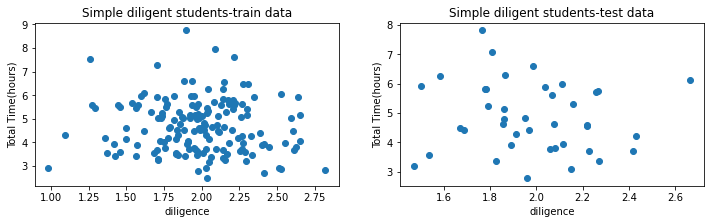

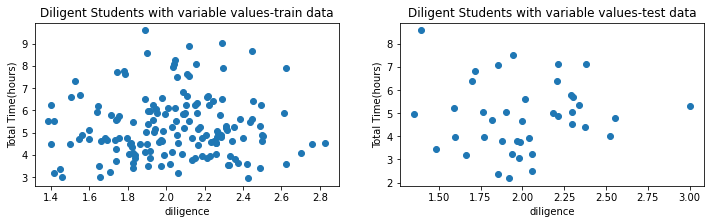

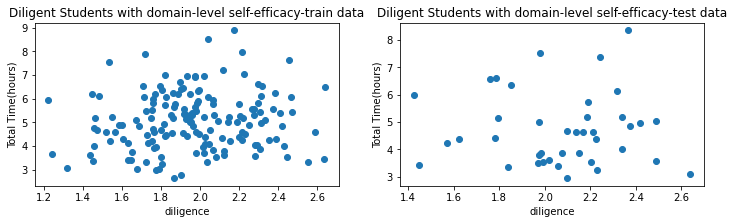

In [121]:
xcol = "diligence"
ycol = "Total Time(hours)"

for desc, splits in stu_stats.items():
    i=0
    plt.figure(figsize=(12,3))
    for split, stat in splits.items():
        plt.subplot(1,len(splits.keys()),i+1)
        plt.title(f"{desc}-{split} data")
        plt.scatter(stat[xcol], stat[ycol])
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        i += 1
    plt.show()

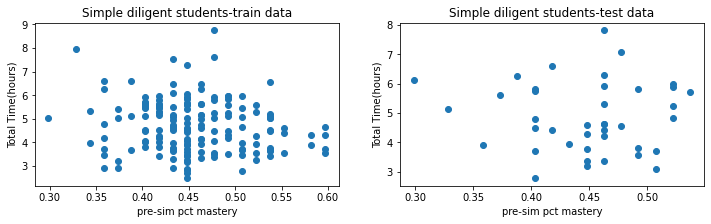

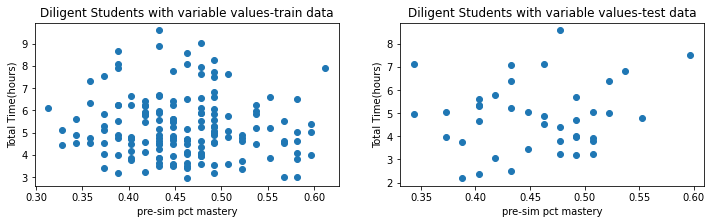

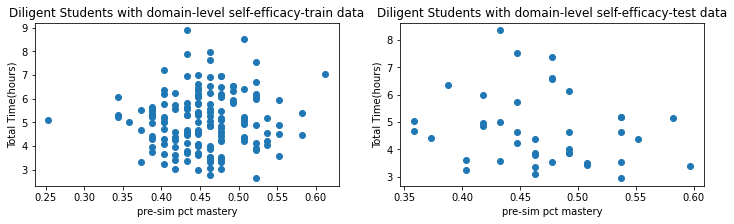

In [122]:
xcol = "pre-sim pct mastery"
ycol = "Total Time(hours)"

for desc, splits in stu_stats.items():
    i=0
    plt.figure(figsize=(12,3))
    for split, stat in splits.items():
        plt.subplot(1,len(splits.keys()),i+1)
        plt.title(f"{desc}-{split} data")
        plt.scatter(stat[xcol], stat[ycol])
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        i += 1
    plt.show()

### Freq of Off-task

INFO:analytics.cae:student set 'Simple diligent students'-train: R = -0.5178487064103199	 pval = 2.339570599096263e-12
INFO:analytics.cae:student set 'Simple diligent students'-test: R = -0.4278118742971932	 pval = 0.005892825809272273


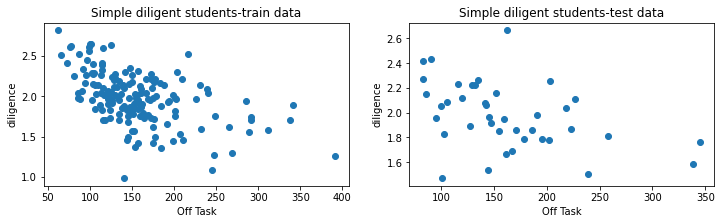

INFO:analytics.cae:student set 'Diligent Students with variable values'-train: R = -0.3289842991016815	 pval = 2.160946664794817e-05
INFO:analytics.cae:student set 'Diligent Students with variable values'-test: R = -0.3143949539511315	 pval = 0.048180197915681136


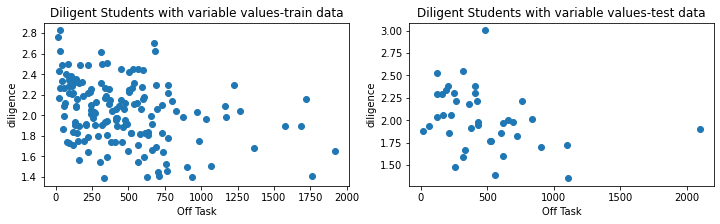

INFO:analytics.cae:student set 'Diligent Students with domain-level self-efficacy'-train: R = -0.3422577287781888	 pval = 9.430119814627935e-06
INFO:analytics.cae:student set 'Diligent Students with domain-level self-efficacy'-test: R = -0.39768397174766706	 pval = 0.011047414672359646


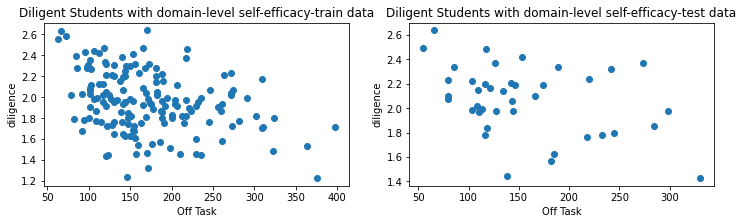

In [123]:
xcol = "Off Task"
ycol = "diligence"

for desc, splits in stu_stats.items():
    i=0
    plt.figure(figsize=(12,3))
    for split, stat in splits.items():
        d1 = stat[xcol]
        d2 = stat[ycol]
        corr, pval = pearsonr(d1, d2)
        logger.info(f"student set '{desc}'-{split}: R = {corr}\t pval = {pval}")
        plt.subplot(1,len(splits.keys()),i+1)
        plt.title(f"{desc}-{split} data")
        plt.scatter(stat[xcol], stat[ycol])
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        i += 1
    plt.show()

#### Regression

INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Simple diligent students -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:              diligence   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     57.90
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           2.34e-12
Time:                        21:27:41   Log-Likelihood:                -22.685
No. Observations:                 160   AIC:                             49.37
Df Residuals:                     158   BIC:                             55.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

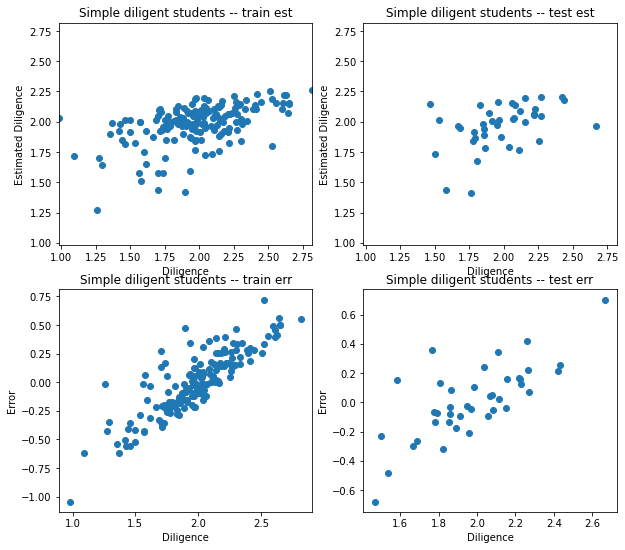

INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Diligent Students with variable values -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:              diligence   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     19.18
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           2.16e-05
Time:                        21:27:42   Log-Likelihood:                -26.991
No. Observations:                 160   AIC:                             57.98
Df Residuals:                     158   BIC:                             64.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 c

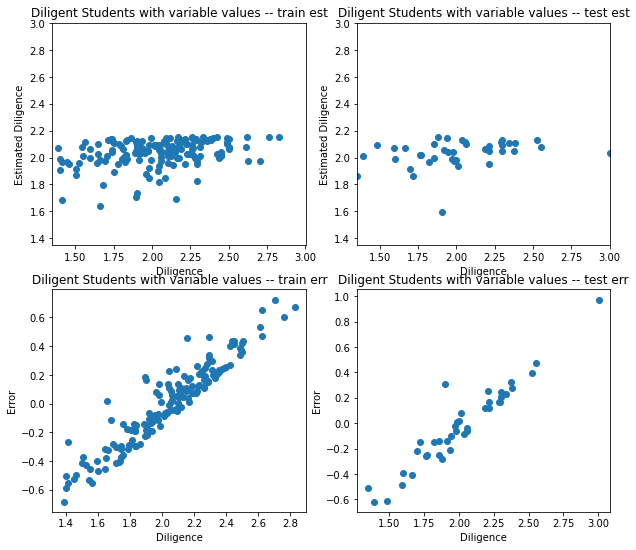

INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Diligent Students with domain-level self-efficacy -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:              diligence   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     20.96
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           9.43e-06
Time:                        21:27:42   Log-Likelihood:                -18.186
No. Observations:                 160   AIC:                             40.37
Df Residuals:                     158   BIC:                             46.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
       

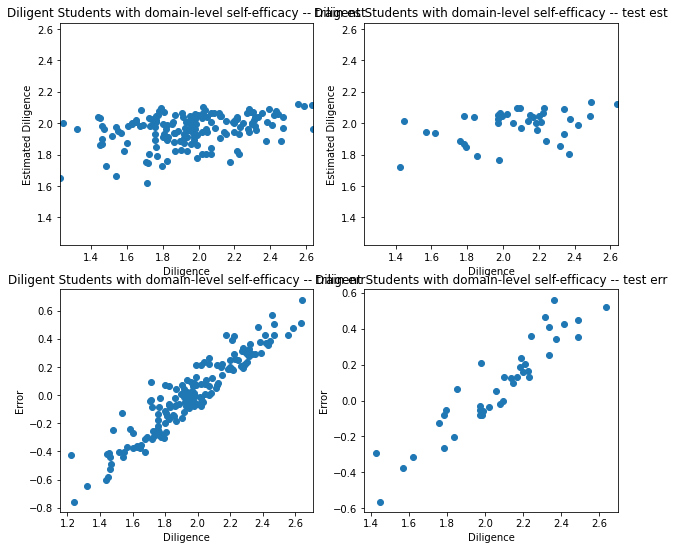

In [124]:
for desc, splits in stu_stats.items():
    stat = splits['train']
    X_train = stat.loc[:, ["Off Task"]]
    X_train = sm.add_constant(X_train)
    Y_train = stat.loc[:, "diligence"]
    model = sm.OLS(Y_train, X_train)
    result = model.fit()
    Y_hat_train = result.predict(X_train)
    err_train = mean_squared_error(Y_train, Y_hat_train)
    logger.info("****************************************************************")
    logger.info(f"Model fit for {desc} -- Training data")
    logger.info(result.summary())
    #logger.info(result.t_test([1]))
    
#    sm.graphics.plot_partregress("diligence", "Off Task", ["Off Task"], data=stat)
    
    stat = splits['test']
    X_test = stat.loc[:, ["Off Task"]]
    X_test = sm.add_constant(X_test)

    Y_test = stat.loc[:, "diligence"]
    Y_hat_test = result.predict(X_test)
    
    err_test = mean_squared_error(Y_test, Y_hat_test)
    logger.info(f"--- MSE train: {err_train}\t test: {err_test} ---")
    
    xmin = np.min([np.min([np.min(Y_train), np.min(Y_test)]), np.min([np.min(Y_hat_train), np.min(Y_hat_test)])])
    xmax = np.max([np.max([np.max(Y_train), np.max(Y_test)]), np.max([np.max(Y_hat_train), np.max(Y_hat_test)])])

#    xmax = np.max([np.max(Y_train), np.max(Y_test), np.max(Y_hat_train), np.max(Y_hat_test)])
    ymin = xmin
    ymax = xmax
    
    
    plt.figure(figsize=(10,9))
    plt.subplot(2,2,1)
    plt.scatter(Y_train, Y_hat_train)
    plt.title(f"{desc} -- train est")
    plt.xlabel("Diligence")
    plt.ylabel("Estimated Diligence")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    plt.subplot(2,2,2)
    plt.scatter(Y_test, Y_hat_test)
    plt.title(f"{desc} -- test est")
    plt.xlabel("Diligence")
    plt.ylabel("Estimated Diligence")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    plt.subplot(2,2,3)
    plt.title(f"{desc} -- train err")
    plt.scatter(Y_train, Y_train - Y_hat_train)
    plt.xlabel("Diligence")
    plt.ylabel("Error")
    
    plt.subplot(2,2,4)
    plt.title(f"{desc} -- test err")
              
    plt.scatter(Y_test, Y_test - Y_hat_test)
    plt.xlabel("Diligence")
    plt.ylabel("Error")
    
    plt.show()
    

### Proportion of Off-task

INFO:analytics.cae:student set 'Simple diligent students'-train: R = -0.8792787156243218	 pval = 9.188258408177282e-53
INFO:analytics.cae:student set 'Simple diligent students'-test: R = -0.8613134196377444	 pval = 9.898100852398326e-13


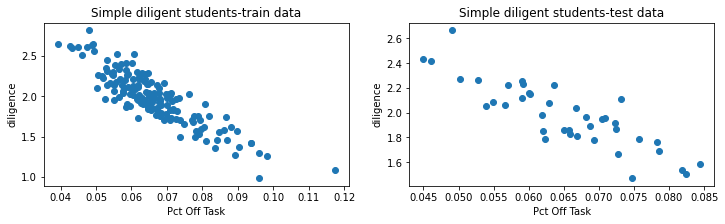

INFO:analytics.cae:student set 'Diligent Students with variable values'-train: R = -0.40894269614455386	 pval = 7.924348522127078e-08
INFO:analytics.cae:student set 'Diligent Students with variable values'-test: R = -0.3296373085088186	 pval = 0.03778740990953083


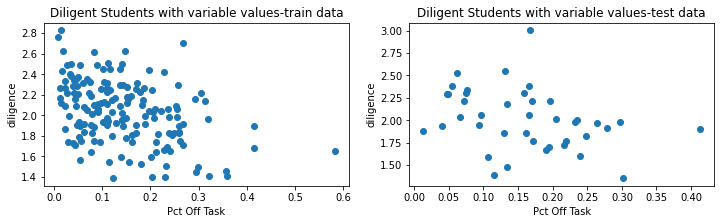

INFO:analytics.cae:student set 'Diligent Students with domain-level self-efficacy'-train: R = -0.7646018188426238	 pval = 5.944526670451013e-32
INFO:analytics.cae:student set 'Diligent Students with domain-level self-efficacy'-test: R = -0.7621109838482867	 pval = 1.1101755699552823e-08


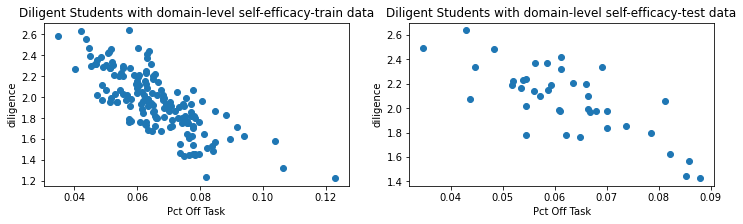

In [114]:
xcol = "Pct Off Task"
ycol = "diligence"


for desc, splits in stu_stats.items():
    i=0
    plt.figure(figsize=(12,3))
    for split, stat in splits.items():
        d1 = stat[xcol]
        d2 = stat[ycol]
        corr, pval = pearsonr(d1, d2)
        logger.info(f"student set '{desc}'-{split}: R = {corr}\t pval = {pval}")
        plt.subplot(1,len(splits.keys()),i+1)
        plt.title(f"{desc}-{split} data")
        plt.scatter(stat[xcol], stat[ycol])
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        i += 1
    plt.show()

#### Regression

INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Simple diligent students -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:              diligence   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     538.4
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           9.19e-53
Time:                        21:28:11   Log-Likelihood:                 71.010
No. Observations:                 160   AIC:                            -138.0
Df Residuals:                     158   BIC:                            -131.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std e

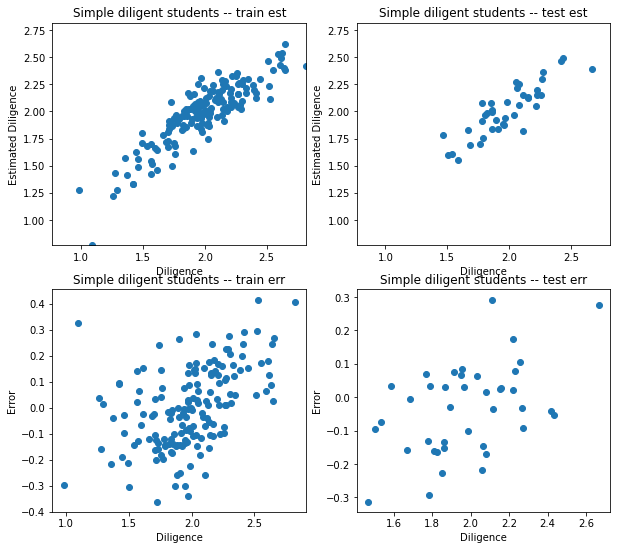

INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Diligent Students with variable values -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:              diligence   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     31.73
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           7.92e-08
Time:                        21:28:12   Log-Likelihood:                -21.515
No. Observations:                 160   AIC:                             47.03
Df Residuals:                     158   BIC:                             53.18
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  

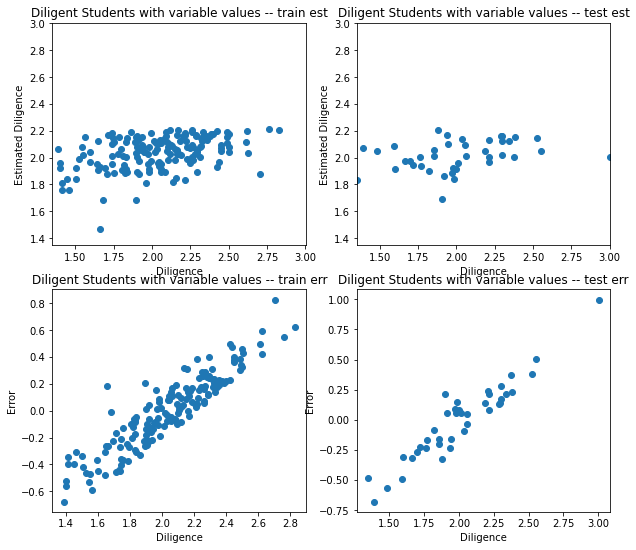

INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Diligent Students with domain-level self-efficacy -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:              diligence   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     222.4
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           5.94e-32
Time:                        21:28:12   Log-Likelihood:                 42.131
No. Observations:                 160   AIC:                            -80.26
Df Residuals:                     158   BIC:                            -74.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
       

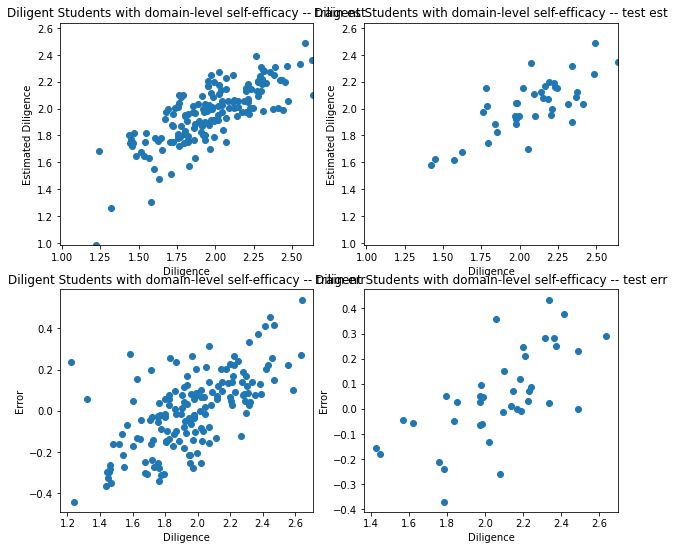

In [125]:
xcols = ["Pct Off Task"]
ycols = "diligence"

for desc, splits in stu_stats.items():
    stat = splits['train']
    
    # Extract student intrinsic EV value of Off Task
    stat[val_col] = stat.apply(lambda x: x['values']["off task"], axis=1)
    
    X_train = stat.loc[:, xcols]
    X_train = sm.add_constant(X_train)
    Y_train = stat.loc[:, ycol]
    model = sm.OLS(Y_train, X_train)
    result = model.fit()
    Y_hat_train = result.predict(X_train)
    err_train = mean_squared_error(Y_train, Y_hat_train)
    logger.info("****************************************************************")
    logger.info(f"Model fit for {desc} -- Training data")
    logger.info(result.summary())
    #logger.info(result.t_test([1]))
    
#    sm.graphics.plot_partregress("diligence", "Off Task", ["Off Task"], data=stat)
    
    stat = splits['test']
    
    # Extract student intrinsic EV value of Off Task
    stat[val_col] = stat.apply(lambda x: x['values']["off task"], axis=1)
    
    X_test = stat.loc[:, xcols]
    X_test = sm.add_constant(X_test)

    Y_test = stat.loc[:, ycol]
    Y_hat_test = result.predict(X_test)
    
    err_test = mean_squared_error(Y_test, Y_hat_test)
    logger.info(f"--- MSE train: {err_train}\t test: {err_test} ---")
    
    xmin = np.min([np.min([np.min(Y_train), np.min(Y_test)]), np.min([np.min(Y_hat_train), np.min(Y_hat_test)])])
    xmax = np.max([np.max([np.max(Y_train), np.max(Y_test)]), np.max([np.max(Y_hat_train), np.max(Y_hat_test)])])

#    xmax = np.max([np.max(Y_train), np.max(Y_test), np.max(Y_hat_train), np.max(Y_hat_test)])
    ymin = xmin
    ymax = xmax
    
    
    plt.figure(figsize=(10,9))
    plt.subplot(2,2,1)
    plt.scatter(Y_train, Y_hat_train)
    plt.title(f"{desc} -- train est")
    plt.xlabel("Diligence")
    plt.ylabel("Estimated Diligence")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    plt.subplot(2,2,2)
    plt.scatter(Y_test, Y_hat_test)
    plt.title(f"{desc} -- test est")
    plt.xlabel("Diligence")
    plt.ylabel("Estimated Diligence")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    plt.subplot(2,2,3)
    plt.title(f"{desc} -- train err")
    plt.scatter(Y_train, Y_train - Y_hat_train)
    plt.xlabel("Diligence")
    plt.ylabel("Error")
    
    plt.subplot(2,2,4)
    plt.title(f"{desc} -- test err")
              
    plt.scatter(Y_test, Y_test - Y_hat_test)
    plt.xlabel("Diligence")
    plt.ylabel("Error")
    
    plt.show()

#### Predicting Pct Off Task

In [159]:
val_col = "Value: Off Task"
xcols = ["diligence", val_col]
ycol = "Pct Off Task"

desc = list(stu_stats.keys())[1]
stat = stu_stats[desc]['train'].copy()

# Extract student intrinsic EV value of Off Task
stat[val_col] = stat.apply(lambda x: x['values']["off task"], axis=1)

X_train = stat.loc[:, xcols]
X_means = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_means) / X_std
X_train = sm.add_constant(X_train)
Y_train = stat.loc[:, ycol]
Y_mean = Y_train.mean()
Y_std = Y_train.std()
Y_Train = (Y_train - Y_mean) / Y_std
model = sm.OLS(Y_train, X_train)
result = model.fit()
Y_hat_train = result.predict(X_train)
err_train = mean_squared_error(Y_train, Y_hat_train)
logger.info("****************************************************************")
logger.info(f"Model fit for {desc} -- Training data")
logger.info(result.summary())
#logger.info(result.t_test([1]))

stat = stu_stats[desc]['test'].copy()

# Extract student intrinsic EV value of Off Task
stat[val_col] = stat.apply(lambda x: x['values']["off task"], axis=1)

X_test = stat.loc[:, xcols]
X_test = (X_test - X_means) / X_std
X_test = sm.add_constant(X_test)

Y_test = stat.loc[:, ycol]
Y_test = (Y_test - Y_mean) / Y_std
Y_hat_test = result.predict(X_test)

err_test = mean_squared_error(Y_test, Y_hat_test)
logger.info(f"--- MSE train: {err_train}\t test: {err_test} ---")


INFO:analytics.cae:****************************************************************
INFO:analytics.cae:Model fit for Diligent Students with variable values -- Training data
INFO:analytics.cae:                            OLS Regression Results                            
Dep. Variable:           Pct Off Task   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     1204.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):           5.89e-96
Time:                        21:56:13   Log-Likelihood:                 370.80
No. Observations:                 160   AIC:                            -735.6
Df Residuals:                     157   BIC:                            -726.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  

### Student-level CAE

In [161]:
def calc_student_cae(d, penalty1, penalty):
    logger.debug(f"calculating CAE on data with shape: {d.shape}")
    stu_id = d['stu_id'][0]
    data_proc = SimpleCAEPreprocessor(d)
    d_proc = data_proc.process_data()

    col_names = d_proc.columns.tolist()
    logger.debug(f"computing cae on dataframe: {d_proc.shape}")
    data_idx = d['_id']
    caa = StudentCAAModel.from_caa_obj(CAAComputation(d_proc.to_numpy(), penalty1, penalty2), data_proc, data_idx, stu_id)
    return caa, col_names


In [162]:
def get_student_caes(sids, db, batch_desc, penalty1, penalty2):
    # Calculate CAA embedding for each student
    logger.debug("Building CAA embedding for each student")
    
    # Get data batches to process from db
    col = "tutor_events"
    base_query = {"stu_id": {"$in": sids},
                  "type": "TutorInput"
                 }
    logger.info(f"{col} collection has {db[col].count_documents(base_query)} documents associated with {len(sids)} students")
    logger.debug(f"Using query: {base_query}")
    segmenter = Segmenter(db[col], base_query)
    idx_fields = ['stu_id']
    caa_batches = segmenter.get_batches(idx_fields, 1)
    caa_mdls = []
    col_names = []
    caa_batch = CAABatch(batch_desc, col_names)

    # Calculate CAA embeddings
    i = 0
    for query, batch in caa_batches:
        if i%25 == 0:
            logger.info(f"Calculating CAE on Student #{i}")
        caa, col_names = calc_student_cae(batch, penalty1, penalty2)
        caa_batch.add(caa)
        i += 1

    caa_batch.col_names = col_names
    
    return caa_batch

In [163]:
def cluster_caes(caa_batch, eps, min_samples):
    logger.info(f"****** Clustering with DBSCAN with EPS={eps} and min_sample={min_samples}******")
    X = caa_batch.get_distances().to_numpy()


    clusterer = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
    clusters = clusterer.fit(X)
    labels = clusters.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    logger.info('Estimated number of clusters: %d' % n_clusters_)
    logger.info('Estimated number of noise points: %d' % n_noise_)
    logger.info(f"Cluster label counts: {pd.Series(clusters.labels_).value_counts()}")
    
    return clusters


In [164]:
def gridsearch_DBSCAN_hyperparams(d, eps_range, min_samples_range):
    for eps in eps_range:
        for min_samples in min_samples_range:
            clusters = cluster_caes(d, eps, min_samples)
            

In [165]:
def get_cae_clusters(caa_batch, eps, min_samples):
    # Map cluster labels with projection ids and original student ids
    clusters = cluster_caes(caa_batch, eps, min_samples)
    y = pd.DataFrame({"proj_id": caa_batch.get_index(), "cluster": clusters.labels_})
    pid_map = {pid: proj.caa_model_id for pid, proj in caa_batch.projections.items()}
    caa_map = {mdl._id: mdl for mdl in caa_batch.mdls}
    pids = pid_map.keys()
    caa_mids = [pid_map[pid] for pid in pids]
    sids = [caa_map[mid].student_id for mid in caa_mids]
    pid_map = pd.DataFrame({"proj_id": pids, "caa_model_id": caa_mids, "student_id": sids})

    # Assemble dataframe with CAE projections for each student
    logger.debug(f"premerge shape: {y.shape}")
    y = pd.merge(y, pid_map, on="proj_id", how="inner")
    logger.debug(f"post-merge shape: {y.shape}")
    cluster_counts = y['cluster'].value_counts()
    for lbl in cluster_counts.index: 
        logger.info(f"Cluster label: {lbl}\t count: {cluster_counts[lbl]}")
     
    # Add columns for each projection axis(u&v) and weighting factor(d)
    y.loc[:, 'US'] = y.apply(lambda x: caa_batch.projections[x['proj_id']].u, axis=1)
    y.loc[:, 'VS'] = y.apply(lambda x: caa_batch.projections[x['proj_id']].v, axis=1)
    y.loc[:, 'd'] = y.apply(lambda x: caa_batch.projections[x['proj_id']].d[0], axis=1)

    # Expand CAE projection axis components into individual columns
    us = y.apply(lambda x: pd.Series(x['US'][0].tolist(), index=caa_batch.col_names), axis=1)
    new_colnames = {col: f"u-{col}" for col in us.columns}
    u_cols = new_colnames.values()
    us.rename(columns=new_colnames, inplace=True)
    vs = y.apply(lambda x: pd.Series(x['VS'][0].tolist(), index=caa_batch.col_names), axis=1)
    new_colnames = {col: f"v-{col}" for col in vs.columns}
    v_cols = new_colnames.values()
    vs.rename(columns=new_colnames, inplace=True)
    y1 = pd.concat([y, us, vs], axis=1)
    logger.info(y1.columns)
    
    return y1

In [189]:
def calc_cae_means(cae, col_names):
    #Calculate the mean of each cluster
    #us = cae.apply(lambda x: pd.Series(x['US'][0].tolist(), index=col_names), axis=1)
    new_colnames = {col: f"u-{col}" for col in col_names}
    u_cols = new_colnames.values()
    #us.rename(columns=new_colnames, inplace=True)
    #vs = cae.apply(lambda x: pd.Series(x['VS'][0].tolist(), index=col_names), axis=1)
    new_colnames = {col: f"v-{col}" for col in col_names}
    v_cols = new_colnames.values()
    #vs.rename(columns=new_colnames, inplace=True)
    
    cluster_center = cae.groupby('cluster')[list(u_cols) + list(v_cols)].mean()
    return cluster_center

In [357]:
def get_reg_df(cae, stu_dict, col_names=None):
    stu_cae = cae.pivot_table(values='d', index='student_id', columns='cluster', fill_value=0, aggfunc=np.sum)
    stu_cae.rename(columns={col: f"cluster_{col}" for col in stu_cae.columns}, inplace=True)
    
    if col_names is not None:
        # Ensure all given columns are present
        for col in col_names:
            if 'cluster' in col and col not in stu_cae.columns:
                stu_cae[col] = np.zeros(stu_cae.shape[0])
        
    
    stu_cae['diligence'] = pd.Series([stu_dict[sid].decider.diligence for sid in stu_cae.index.tolist()], index=stu_cae.index)

    # Drop the noise cluster (-1)
    drop_col = 'cluster_-1'
    if drop_col in stu_cae.columns:
        stu_cae.drop(columns=[drop_col], inplace=True) 
    
    return stu_cae


    

#### Calculate Embeddings

In [327]:
caa_batches = {desc: {"train": None, 'test': None} for desc in batch_desc}

for bdesc in batch_desc:
    train_sids = get_train_data(bdesc)
    test_sids = get_test_data(bdesc) 
    
    lmapper = DBLearnerMapper(db)
    students = [lmapper.get_modlearner_from_db(stu_id) for stu_id in train_sids]
    stu_dict = {stu._id: stu for stu in students}
    
    eps = 0.8
    min_samples = 5
    penalty1 = 0.35
    penalty2 = 0.35
    
    caa_batches[bdesc]['train'] = get_student_caes(train_sids, db, bdesc, penalty1, penalty2)

    # Presist CAE Models
    db.caa_models.insert_many([mdl.to_dict() for mdl in caa_batches[bdesc]['train'].mdls])
    db.caa_batches.insert_one(caa_batches[bdesc]['train'].to_dict())

    caa_batches[bdesc]['test'] = get_student_caes(test_sids, db, bdesc, penalty1, penalty2)

    # Presist CAE Models
    db.caa_models.insert_many([mdl.to_dict() for mdl in caa_batches[bdesc]['test'].mdls])
    db.caa_batches.insert_one(caa_batches[bdesc]['test'].to_dict())
    

INFO:analytics.cae:tutor_events collection has 350404 documents associated with 160 students
INFO:analytics.cae:Calculating CAE on Student #0
INFO:analytics.cae:Calculating CAE on Student #25
INFO:analytics.cae:Calculating CAE on Student #50
INFO:analytics.cae:Calculating CAE on Student #75
INFO:analytics.cae:Calculating CAE on Student #100
INFO:analytics.cae:Calculating CAE on Student #125
INFO:analytics.cae:Calculating CAE on Student #150
INFO:analytics.cae:tutor_events collection has 91710 documents associated with 40 students
INFO:analytics.cae:Calculating CAE on Student #0
INFO:analytics.cae:Calculating CAE on Student #25
INFO:analytics.cae:tutor_events collection has 415562 documents associated with 160 students
INFO:analytics.cae:Calculating CAE on Student #0
INFO:analytics.cae:Calculating CAE on Student #25
INFO:analytics.cae:Calculating CAE on Student #50
INFO:analytics.cae:Calculating CAE on Student #75
INFO:analytics.cae:Calculating CAE on Student #100
INFO:analytics.cae:Cal

#### Cluster/Label Embeddings

In [331]:
caa_clusters = {desc: {'train_clusters': None, 'train_distances': None, 'test_distances': None, 'test_clusters': None} for desc in batch_desc}
for bdesc in batch_desc:
    # Cluster training data    
    test_batch = caa_batches[bdesc]['test']
    train_batch = caa_batches[bdesc]['train']
    
    stu_cae = get_cae_clusters(train_batch, eps, min_samples)
    
    cluster_centers = calc_cae_means(stu_cae, train_batch.col_names)
    logger.info(f"***************** Cluster centers for set: {bdesc} *****************")
    logger.info(cluster_centers.head(cluster_centers.shape[0]))
    
    train_distances = train_batch.get_distances()
    
    X = train_distances
    train_cluster_labels = stu_cae.loc[:, ['proj_id', 'cluster']].copy()
    train_cluster_labels.index = train_cluster_labels['proj_id']
    train_cluster_labels.drop(columns=['proj_id'], inplace=True)
    Y = pd.Series([train_cluster_labels.loc[pid][0] for pid in X.index], index=X.index)

    # Calc distance of test data to train data
    rows = test_batch.get_index()
    cols = X.index
    test_distances = pd.DataFrame(index=rows, columns=cols)
    for i in rows:
        for j in cols:
            p1 = test_batch.projections[i]
            p2 = train_batch.projections[j]
            d = CAAProjection.distance(p1, p2)
            test_distances.loc[i,j] = d
    
    caa_clusters[bdesc]['train_clusters'] = stu_cae
    caa_clusters[bdesc]['train_distances'] = train_distances
    caa_clusters[bdesc]['test_distances'] = test_distances
    

INFO:analytics.cae:****** Clustering with DBSCAN with EPS=0.8 and min_sample=5******
INFO:analytics.cae:Estimated number of clusters: 10
INFO:analytics.cae:Estimated number of noise points: 9
INFO:analytics.cae:Cluster label counts:  0    154
 1    136
 2     91
 3     78
 4     47
 6     41
 5     22
 8     16
 7     10
-1      9
 9      7
dtype: int64
INFO:analytics.cae:Cluster label: 0	 count: 154
INFO:analytics.cae:Cluster label: 1	 count: 136
INFO:analytics.cae:Cluster label: 2	 count: 91
INFO:analytics.cae:Cluster label: 3	 count: 78
INFO:analytics.cae:Cluster label: 4	 count: 47
INFO:analytics.cae:Cluster label: 6	 count: 41
INFO:analytics.cae:Cluster label: 5	 count: 22
INFO:analytics.cae:Cluster label: 8	 count: 16
INFO:analytics.cae:Cluster label: 7	 count: 10
INFO:analytics.cae:Cluster label: -1	 count: 9
INFO:analytics.cae:Cluster label: 9	 count: 7
INFO:analytics.cae:Index(['proj_id', 'cluster', 'caa_model_id', 'student_id', 'US', 'VS', 'd',
       'u-duration', 'u-plt', '

In [332]:
# Classify Test data
n_neighbors = 10

for bdesc in batch_desc:
    test_batch = caa_batches[bdesc]['test']
    train_batch = caa_batches[bdesc]['train']
    test_distances = caa_clusters[bdesc]['test_distances']
    
    X = caa_clusters[bdesc]['train_distances']
    train_cluster_labels = caa_clusters[bdesc]['train_clusters'].loc[:, ['proj_id', 'cluster']].copy()
    train_cluster_labels.index = train_cluster_labels['proj_id']
    train_cluster_labels.drop(columns=['proj_id'], inplace=True)
    Y = pd.Series([train_cluster_labels.loc[pid][0] for pid in X.index], index=X.index)
    
    # Classify test projections with embedding cluster labels
    clf = neighbors.KNeighborsClassifier(n_neighbors, metric='precomputed')
    clf.fit(X.to_numpy(), Y.to_numpy())
    Y_hat_test = clf.predict(test_distances)

    #Format test data with labels for feeding to fitted regression model
    test_clusters = pd.DataFrame({"proj_id": test_distances.index, "cluster": Y_hat_test})
    pid_map = {pid: proj.caa_model_id for pid, proj in test_batch.projections.items()}
    caa_map = {mdl._id: mdl for mdl in test_batch.mdls}
    pids = pid_map.keys()
    caa_mids = [pid_map[pid] for pid in pids]
    sids = [caa_map[mid].student_id for mid in caa_mids]
    pid_map = pd.DataFrame({"proj_id": pids, "caa_model_id": caa_mids, "student_id": sids})

    # Assemble dataframe with CAE projections for each student
    logger.debug(f"premerge shape: {test_clusters.shape}")
    test_clusters = pd.merge(test_clusters, pid_map, on="proj_id", how="inner")
    logger.debug(f"post-merge shape: {test_clusters.shape}")
    cluster_counts = test_clusters['cluster'].value_counts()
    for lbl in cluster_counts.index: 
        logger.info(f"Cluster label: {lbl}\t count: {cluster_counts[lbl]}")

    # Add columns for each projection axis(u&v) and weighting factor(d)
    test_clusters.loc[:, 'US'] = test_clusters.apply(lambda x: test_batch.projections[x['proj_id']].u, axis=1)
    test_clusters.loc[:, 'VS'] = test_clusters.apply(lambda x: test_batch.projections[x['proj_id']].v, axis=1)
    test_clusters.loc[:, 'd'] = test_clusters.apply(lambda x: test_batch.projections[x['proj_id']].d[0], axis=1)

    # Expand CAE projection axis components into individual columns
    us = test_clusters.apply(lambda x: pd.Series(x['US'][0].tolist(), index=test_batch.col_names), axis=1)
    new_colnames = {col: f"u-{col}" for col in us.columns}
    u_cols = new_colnames.values()
    us.rename(columns=new_colnames, inplace=True)
    vs = test_clusters.apply(lambda x: pd.Series(x['VS'][0].tolist(), index=test_batch.col_names), axis=1)
    new_colnames = {col: f"v-{col}" for col in vs.columns}
    v_cols = new_colnames.values()
    vs.rename(columns=new_colnames, inplace=True)
    test_clusters = pd.concat([test_clusters, us, vs], axis=1)
    logger.info(test_clusters.columns)
    
    caa_clusters[bdesc]['test_clusters'] = test_clusters

INFO:analytics.cae:Cluster label: 0	 count: 40
INFO:analytics.cae:Cluster label: 1	 count: 36
INFO:analytics.cae:Cluster label: 2	 count: 25
INFO:analytics.cae:Cluster label: 3	 count: 22
INFO:analytics.cae:Cluster label: 6	 count: 13
INFO:analytics.cae:Cluster label: 4	 count: 13
INFO:analytics.cae:Cluster label: 5	 count: 7
INFO:analytics.cae:Cluster label: 8	 count: 6
INFO:analytics.cae:Cluster label: 7	 count: 4
INFO:analytics.cae:Cluster label: 9	 count: 3
INFO:analytics.cae:Index(['proj_id', 'cluster', 'caa_model_id', 'student_id', 'US', 'VS', 'd',
       'u-duration', 'u-plt', 'u-plt1', 'u-hints_used', 'u-hints_avail',
       'u-attempt', 'u-Hint', 'u-Incorrect', 'v-duration', 'v-plt', 'v-plt1',
       'v-hints_used', 'v-hints_avail', 'v-attempt', 'v-Hint', 'v-Incorrect'],
      dtype='object')
INFO:analytics.cae:Cluster label: 0	 count: 39
INFO:analytics.cae:Cluster label: 1	 count: 32
INFO:analytics.cae:Cluster label: 4	 count: 18
INFO:analytics.cae:Cluster label: 3	 count: 18

#### Regression estimating Diligence

INFO:analytics.cae:************ Regression for student set: Simple diligent students *****************
INFO:analytics.cae:                                 OLS Regression Results                                
Dep. Variable:              diligence   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              543.6
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                   5.11e-109
Time:                        18:51:46   Log-Likelihood:                         -43.722
No. Observations:                 154   AIC:                                      107.4
Df Residuals:                     144   BIC:                                      137.8
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                 

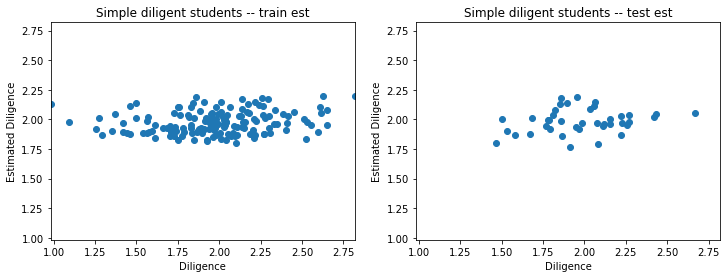

INFO:analytics.cae:************ Regression for student set: Diligent Students with variable values *****************
INFO:analytics.cae:                                 OLS Regression Results                                
Dep. Variable:              diligence   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              661.6
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                   6.20e-112
Time:                        18:51:49   Log-Likelihood:                         -30.129
No. Observations:                 149   AIC:                                      80.26
Df Residuals:                     139   BIC:                                      110.3
Df Model:                          10                                                  
Covariance Type:            nonrobust                                   

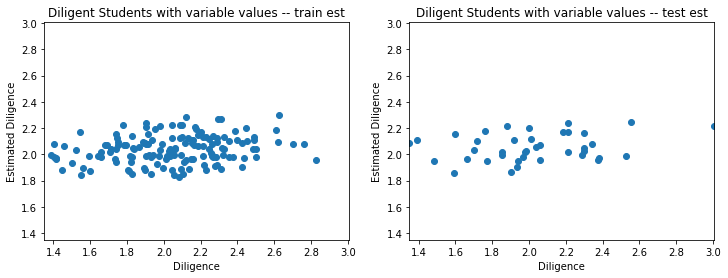

INFO:analytics.cae:************ Regression for student set: Diligent Students with domain-level self-efficacy *****************
INFO:analytics.cae:                                 OLS Regression Results                                
Dep. Variable:              diligence   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.976
Method:                 Least Squares   F-statistic:                              569.3
Date:                Tue, 12 Jan 2021   Prob (F-statistic):                   6.29e-111
Time:                        18:51:51   Log-Likelihood:                         -29.471
No. Observations:                 152   AIC:                                      80.94
Df Residuals:                     141   BIC:                                      114.2
Df Model:                          11                                                  
Covariance Type:            nonrobust                        

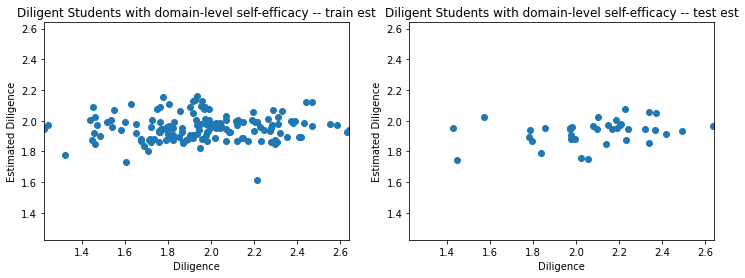

In [358]:
# Regression

for bdesc in batch_desc:
    stu_cae = caa_clusters[bdesc]['train_clusters']
    test_sids = get_test_data(bdesc)
    train_sids = get_train_data(bdesc)
    test_clusters = caa_clusters[bdesc]['test_clusters']
    
    train_students = [lmapper.get_modlearner_from_db(stu_id) for stu_id in train_sids]
    train_stu_dict = {stu._id: stu for stu in train_students}

    # Format training data for regression
    train_d = get_reg_df(stu_cae, train_stu_dict)
    
    # Regression on Training Data
    xcols = [col for col in train_d.columns.tolist() if "cluster" in col]
    ycol = "diligence"
    X_train = train_d.loc[:, xcols]
    Y_train = train_d.loc[:, ycol]
    mdl = sm.OLS(Y_train, X_train).fit()
    
    logger.info(f"************ Regression for student set: {bdesc} *****************")
    logger.info(mdl.summary())

    Y_hat_train = mdl.predict(X_train)
    mse_train = mean_squared_error(Y_train, Y_hat_train)

    # Predictions of model on Test Data
    test_students = [lmapper.get_modlearner_from_db(stu_id) for stu_id in test_sids]
    test_stu_dict = {stu._id: stu for stu in test_students}
    test_d = get_reg_df(test_clusters, test_stu_dict, train_d.columns)

    xcols = [col for col in test_d.columns.tolist() if "cluster" in col]
    ycol = "diligence"
    X_test = test_d.loc[:, xcols]
    Y_test = test_d.loc[:, ycol]
    Y_hat_test = mdl.predict(X_test.to_numpy())
    mse_test = mean_squared_error(Y_test, Y_hat_test)


    logger.info(f"Mean square Error. Training: {mse_train}\t Test: {mse_test}")
    
    # Plot Predictions
    xmin = np.min([np.min([np.min(Y_train), np.min(Y_test)]), np.min([np.min(Y_hat_train), np.min(Y_hat_test)])])
    xmax = np.max([np.max([np.max(Y_train), np.max(Y_test)]), np.max([np.max(Y_hat_train), np.max(Y_hat_test)])])

    ymin = xmin
    ymax = xmax


    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.scatter(Y_train, Y_hat_train)
    plt.title(f"{bdesc} -- train est")
    plt.xlabel("Diligence")
    plt.ylabel("Estimated Diligence")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    plt.subplot(1,2,2)
    plt.scatter(Y_test, Y_hat_test)
    plt.title(f"{bdesc} -- test est")
    plt.xlabel("Diligence")
    plt.ylabel("Estimated Diligence")
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    
    plt.show()

## Comparing Diligence Estimates

In [ ]:
print("test")

# Summary of Results

Estimating Diligence

Simple Diligent Students
Freq of Off Task
 R-squared:                       0.268             
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4536      0.066     37.251      0.000       2.323       2.584
Off Task      -0.0030      0.000     -7.609      0.000      -0.004      -0.002

MSE train: 0.07774522739314112	 test: 0.061369836999304025 ---

Proportion of Off Task
R-squared:                       0.773
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5573      0.069     51.542      0.000       3.421       3.694
Pct Off Task   -23.7765      1.025    -23.204      0.000     -25.800     -21.753

MSE train: 0.024101105255305937	 test: 0.01882725256654274 ---

Student-level CAE
R-squared:                   0.974                                 
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cluster_0      1.9168      0.073     26.214      0.000       1.772       2.061
cluster_1      0.0115      0.097      0.118      0.906      -0.181       0.204
cluster_2     -0.0849      0.127     -0.671      0.503      -0.335       0.165
cluster_3     -0.0509      0.158     -0.322      0.748      -0.364       0.262
cluster_4     -0.1387      0.203     -0.683      0.496      -0.540       0.263
cluster_5      0.2044      0.358      0.572      0.568      -0.502       0.911
cluster_6      0.0392      0.184      0.213      0.832      -0.325       0.403
cluster_7     -0.5075      0.416     -1.220      0.225      -1.330       0.315
cluster_8      0.3273      0.396      0.827      0.410      -0.455       1.110
cluster_9     -0.3256      0.495     -0.658      0.511      -1.303       0.652

Mean square Error. Training: 0.10330573607269716	 Test: 0.06715947920995932

Diligent with Self Eff
Freq of Off Task
R-squared:                       0.117
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2208      0.061     36.417      0.000       2.100       2.341
Off Task      -0.0015      0.000     -4.579      0.000      -0.002      -0.001
MSE train: 0.07349436743083963	 test: 0.07244362732771051 ---

Prportion of Off Task
R-squared:                       0.585                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.0817      0.077     40.186      0.000       2.930       3.233
Pct Off Task   -17.0734      1.145    -14.912      0.000     -19.335     -14.812
MSE train: 0.03457898288803763	 test: 0.03495325673500937 ---

Student-level CAE
R-squared (uncentered):                   0.978
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cluster_0      1.9334      0.110     17.600      0.000       1.716       2.151
cluster_1     -0.0632      0.133     -0.477      0.634      -0.326       0.199
cluster_2     -0.2080      0.159     -1.305      0.194      -0.523       0.107
cluster_3      0.1580      0.132      1.198      0.233      -0.103       0.419
cluster_4      0.1984      0.173      1.146      0.254      -0.144       0.541
cluster_5      0.3499      0.303      1.156      0.250      -0.249       0.948
cluster_6     -0.3941      0.158     -2.493      0.014      -0.707      -0.082
cluster_7     -0.5619      0.829     -0.678      0.499      -2.201       1.077
cluster_8      0.2437      0.446      0.547      0.585      -0.637       1.125
cluster_9     -0.0273      0.364     -0.075      0.940      -0.746       0.692
cluster_10     0.1211      0.480      0.253      0.801      -0.827       1.069
Mean square Error. Training: 0.08628441695987324	 Test: 0.08708041617099727

Diligent with Variable Values
R-squared:                       0.108
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1613      0.036     59.383      0.000       2.089       2.233
Off Task      -0.0003   6.19e-05     -4.379      0.000      -0.000      -0.000
MSE train: 0.08204510192737742	 test: 0.0999426924595668 ---

Proportion of Off Task
 R-squared:                       0.167    
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2215      0.039     56.291      0.000       2.144       2.299
Pct Off Task    -1.2874      0.229     -5.633      0.000      -1.739      -0.836
MSE train: 0.07661662990542648	 test: 0.09838867761509369 ---

R-squared (uncentered):                   0.979
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cluster_0      1.8089      0.089     20.248      0.000       1.632       1.986
cluster_1      0.1390      0.113      1.231      0.220      -0.084       0.362
cluster_2     -0.4651      0.159     -2.919      0.004      -0.780      -0.150
cluster_3      0.1553      0.160      0.973      0.332      -0.160       0.471
cluster_4      0.0198      0.186      0.106      0.915      -0.348       0.387
cluster_5     -0.0578      0.251     -0.231      0.818      -0.554       0.438
cluster_6     -0.5464      0.369     -1.480      0.141      -1.277       0.184
cluster_7      0.4037      0.464      0.869      0.386      -0.514       1.322
cluster_8      0.5987      0.342      1.750      0.082      -0.078       1.275
cluster_9     -0.2720      0.549     -0.495      0.621      -1.358       0.814
Mean square Error. Training: 0.0877327981501877	 Test: 0.1069420444781655

# Write results to file

In [15]:
#result_out = os.path.join(base_dir, )
out_dirs = ["test", "data", "simple_compare_dil_est"]
out_path = base_dir
for out_dir in out_dirs:
    out_path = os.path.join(out_path, out_dir)
    if not os.path.exists(out_path):
        logger.info(f"Creating output directory: {out_path}")
        os.mkdir(out_path)
logger.info(f"Writing db output to: {out_path}")
db_util.dump_db(data_dir=out_path)
logger.info("Done")


INFO:analytics.cae:Creating output directory: /rdata/Sandbox/MotivSim/test
INFO:analytics.cae:Creating output directory: /rdata/Sandbox/MotivSim/test/data
INFO:analytics.cae:Creating output directory: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est
INFO:analytics.cae:Writing db output to: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est
INFO:log_db.mongo:writing 67 documents to file: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est/kcs.json
INFO:log_db.mongo:writing 8 documents to file: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est/caa_batches.json
INFO:log_db.mongo:writing 3 documents to file: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est/simbatches.json
INFO:log_db.mongo:writing 800 documents to file: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est/caa_models.json
INFO:log_db.mongo:writing 1 documents to file: /rdata/Sandbox/MotivSim/test/data/simple_compare_dil_est/domains.json
INFO:log_db.mongo:writing 600 documents to file: /